Welcome to the neural network exercise! Here you will have a chance to train a neural network to recognize 
hand-written digits that have been collected by MNIST ("Modified National Institute of Standards and Technology"). This problem is very classical and is considered the "Hello World" of computer vision.


!["Digits"](images/digits.png)


To make things easier for you I have given you code to train a simple neural network. You can run the code to see the network learning. Each epoch should improve the accuracy on the training-set. When you are done training
you can take a look at the first layer of neural network weights visualized as images. What has the neural network learned? How is it classifying digits?

The neural network that I have given you is very simple, consisting of only a single layer. However, when 
neural networks get more complicated there is always a risk of over-fitting, especially if the number of trainable parameters is too big in relation to the dataset size. To learn more about overfitting you should perform the following steps.

- Step 1: Expand the "train_network" function so that it also computes the accuracy score on the validation data "val_df". Be careful to seperate your validation calculations from the training optimization step. 
The function optimizer.zero_grad() resets the gradient, and can be used to wipe out whatever information has been retained after validation calculations. How does the validation accuracy compare to the training accuracy for the single layer neural network?

- Step 2: Create a new neural network with at least 3 layers, you can progressively downsample the data until you reach 10 outputs. Add in relu functions between the layers. Train this new network with a training dataset which only has a single image for each digit. How does the validation accuracy compare to the training accuracy? Try to visualize the first layer weights, can you see what the network has learned?

- Step 3: Now use the full dataset and you new network. Can you improve your validation accuracy score by adding more layers to the network?

If that was very easy for you and you would like to keep learning about neural networks you can try the bonus task.

- Bonus: Try to create a neural network which achieves as high a validation accuracy as possible. You can play with the neural network architecture, and learning parameters: learning rate, batch size, and number of epochs. When you think you have a good neural network you can try to make a prediction on the test data data/mnist_digits/test.csv, and submit it to [Kaggle](https://www.kaggle.com/c/digit-recognizer). How much test set accuracy can you achieve?

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
#Load the Data
class MnistData(Dataset):
    def __init__(self, digits_data):
        self.labels = np.array(OneHotEncoder().fit_transform(digits_data.values[:,0][:,np.newaxis]).todense()).astype(np.single)
        self.imdata = (digits_data.values[:,1:]/255.0).astype(np.single)
    
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, index):
        return self.labels[index], self.imdata[index]

    def visualize(self, index):
        plt.imshow(self.imdata[index].reshape(28,28), cmap = plt.cm.bone)

        
digits_data = pd.read_csv("data/mnist_digits/train.csv")
train_df, val_df = train_test_split(digits_data, test_size = 0.3)

train_digits = MnistData(train_df)
val_digits = MnistData(val_df)

In [3]:
#Define the neural network
class SingleLayerDigitNet(nn.Module):
    def __init__(self):
        super(SingleLayerDigitNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 10)
    
    def forward(self, x):
        x = self.fc1(x)
        return x

In [4]:
singlelayer_digitnet = SingleLayerDigitNet() #Creates a new untrained network

True label is 9, nn prediction is 8


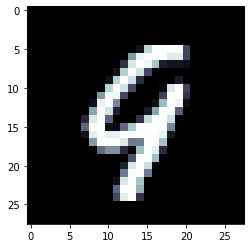

In [5]:
#Try making some test predictions with the untrained network
imnum = 11

label, imdata = train_digits[imnum]

pred_label = np.argmax(singlelayer_digitnet(torch.Tensor(imdata)).detach().numpy())
print("True label is {}, nn prediction is {}".format(np.argmax(label), pred_label))
train_digits.visualize(imnum)
plt.savefig("digit_6.png")

In [6]:
#Helper class for Neural Network training
class TrainingStats(object):
    def __init__(self):
        self.losses = []
        self.accs = []
        self.reset_runningdata()
        
    def reset_runningdata(self):
        self.loss_running = 0
        self.predictions_running = []
        self.labels_running = []
    
    def add(self, predictions, labels, loss):
        self.loss_running += loss
        self.predictions_running.append(predictions)
        self.labels_running.append(labels)
        
    def new_epoch(self):
        self.losses.append(self.loss_running)
        preds = np.hstack(self.predictions_running)
        labels = np.hstack(self.labels_running)
        
        self.accs.append(100*(preds == labels).sum()/len(labels))
        self.reset_runningdata()

#Network training function
def train_network(train_dataloader, val_dataloader, model, loss_func, optimizer, train_params):
    trainstats = TrainingStats()
    valstats = TrainingStats()
    
    print("Epoch, train loss, train acc, val loss, val acc")
    for epochnum in range(train_params["epochs"]):
        #Get validation stats
        for val_data in val_dataloader:
            val_labels = val_data[0]
            val_images = val_data[1]
            
            val_prediction = model(val_images)
            val_loss = loss_func(val_prediction, val_labels).item()
            #print(val_loss)
            
        valstats.add(np.argmax(val_prediction.detach().numpy(), axis = 1), 
                     np.argmax(val_labels.detach().numpy(), axis = 1),
                     val_loss)
        valstats.new_epoch()
            
        #Train the model
        for batch_idx, data_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
    
            label_batch = data_batch[0]
            image_batch = data_batch[1]
    
            train_prediction = model(image_batch)
            train_loss       = loss_func(train_prediction, label_batch)

            train_loss.backward()
            optimizer.step()
            
            trainstats.add(np.argmax(train_prediction.detach().numpy(), axis = 1),
                           np.argmax(label_batch.detach().numpy(), axis = 1),
                           train_loss.item())
    
        trainstats.new_epoch()
            
        print("{} {:.2f} {:.2f}% {:.2f} {:.2f}%".format(epochnum, 
                                                        trainstats.losses[-1]/len(training_dataloader.dataset),
                                                        trainstats.accs[-1],
                                                        valstats.losses[-1]/len(val_dataloader.dataset),
                                                        valstats.accs[-1]))
    return trainstats, valstats

In [7]:
train_params = {"epochs": 25,
                "batch_size": 5,
                "learningRate": 0.001}

#singlelayer_digitnet = SingleLayerDigitNet() #retrain from start

training_dataloader = torch.utils.data.DataLoader(train_digits,
                                                  batch_size = train_params["batch_size"])

val_dataloader = torch.utils.data.DataLoader(val_digits,
                                             batch_size = len(val_digits))

loss_func = torch.nn.BCEWithLogitsLoss(reduce = "mean")
optimizer = torch.optim.SGD(singlelayer_digitnet.parameters(),
                            lr = train_params['learningRate'])

trainstats, valstats = train_network(training_dataloader,
                                     val_dataloader,
                                     singlelayer_digitnet,
                                     loss_func,
                                     optimizer,
                                     train_params)


Epoch, train loss, train acc, val loss, val acc


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


0 0.07 49.75% 0.00 10.70%
1 0.05 74.29% 0.00 70.64%
2 0.05 78.22% 0.00 76.98%
3 0.04 79.94% 0.00 79.42%
4 0.04 81.02% 0.00 80.85%
5 0.04 81.79% 0.00 81.75%
6 0.04 82.34% 0.00 82.37%
7 0.03 82.75% 0.00 82.96%
8 0.03 83.12% 0.00 83.29%
9 0.03 83.44% 0.00 83.57%
10 0.03 83.77% 0.00 83.89%
11 0.03 84.02% 0.00 84.13%
12 0.03 84.28% 0.00 84.36%
13 0.03 84.49% 0.00 84.56%
14 0.03 84.69% 0.00 84.78%
15 0.03 84.85% 0.00 85.04%
16 0.03 84.98% 0.00 85.21%
17 0.03 85.15% 0.00 85.44%
18 0.03 85.30% 0.00 85.55%
19 0.03 85.45% 0.00 85.68%
20 0.03 85.57% 0.00 85.85%
21 0.03 85.70% 0.00 85.98%
22 0.02 85.81% 0.00 86.14%
23 0.02 85.92% 0.00 86.22%
24 0.02 86.03% 0.00 86.32%


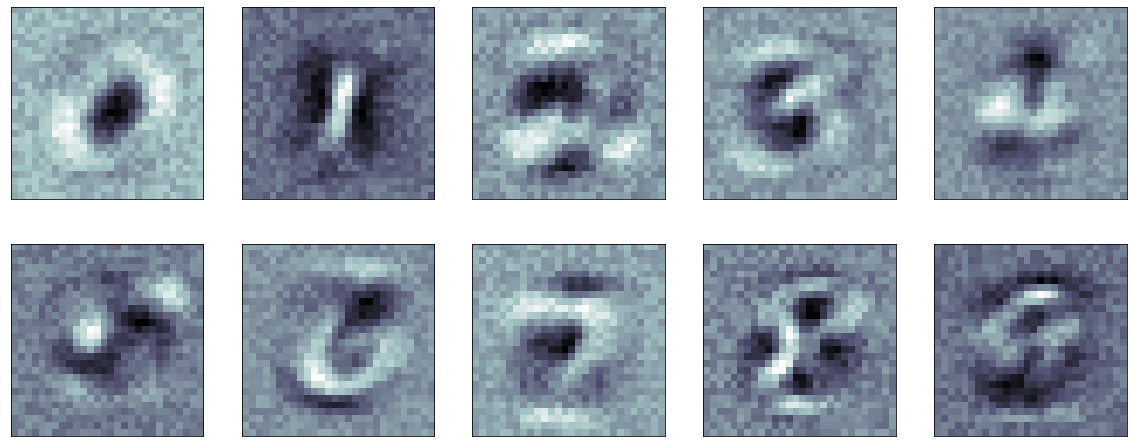

In [8]:
def visualize_firstlayer_weights(network):    
    for m in network.modules():
        if isinstance(m, nn.Linear):
            weights = m.weight        
            break
    
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8),
                           subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axs.flat):    
        ax.imshow(weights[i].detach().numpy().reshape(28, 28), 
                  plt.cm.bone)

#The weights look like the numbers, the model has learned useful and generalizable features!
visualize_firstlayer_weights(singlelayer_digitnet)

In [9]:
#Train a more complicated network with less data

train_params = {"epochs": 25,
                "batch_size": 2,
                "learningRate": 0.01}

#Define the neural network
class MultiLayerDigitNet(nn.Module):
    def __init__(self):
        super(MultiLayerDigitNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 14*14)
        self.fc2 = nn.Linear(14*14, 100)
        self.fc3 = nn.Linear(100, 10)
    
    def forward(self, x):
        relu = nn.ReLU()     
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        x = relu(x)
        x = self.fc3(x)
        return x

multilayer_digitnet = MultiLayerDigitNet() #retrain from start

training_dataloader_minimum_data = torch.utils.data.DataLoader(MnistData(train_df.groupby("label").first().reset_index()),
                                                                         batch_size = train_params["batch_size"])

optimizer = torch.optim.SGD(multilayer_digitnet.parameters(),
                            lr = train_params['learningRate'])

trainstats, valstats = train_network(training_dataloader_minimum_data,
                                     val_dataloader,
                                     multilayer_digitnet,
                                     loss_func,
                                     optimizer,
                                     train_params)

#The accuracy is very high for the training data but poor for the validation data.
#The model is overfitting

Epoch, train loss, train acc, val loss, val acc
0 0.00 20.00% 0.00 15.63%
1 0.00 20.00% 0.00 15.53%
2 0.00 20.00% 0.00 15.53%
3 0.00 20.00% 0.00 15.41%
4 0.00 20.00% 0.00 15.36%
5 0.00 20.00% 0.00 15.21%
6 0.00 20.00% 0.00 15.14%
7 0.00 20.00% 0.00 15.06%
8 0.00 20.00% 0.00 15.01%
9 0.00 20.00% 0.00 14.91%
10 0.00 20.00% 0.00 14.85%
11 0.00 20.00% 0.00 14.79%
12 0.00 20.00% 0.00 14.73%
13 0.00 20.00% 0.00 14.67%
14 0.00 20.00% 0.00 14.56%
15 0.00 20.00% 0.00 14.48%
16 0.00 20.00% 0.00 14.40%
17 0.00 20.00% 0.00 14.32%
18 0.00 20.00% 0.00 14.23%
19 0.00 20.00% 0.00 14.18%
20 0.00 20.00% 0.00 14.14%
21 0.00 20.00% 0.00 14.06%
22 0.00 20.00% 0.00 13.93%
23 0.00 20.00% 0.00 13.87%
24 0.00 20.00% 0.00 13.78%


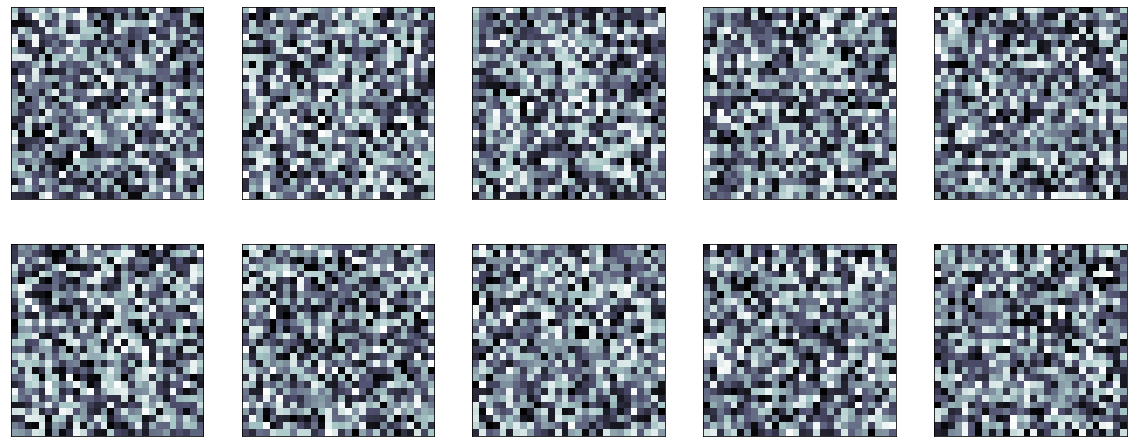

In [10]:
#The weights are no longer recognizable
visualize_firstlayer_weights(multilayer_digitnet)

In [12]:
#Now train the deeper network with all the data
train_params = {"epochs": 20,
                "batch_size": 20,
                "learningRate": 0.001,
                "momentum": 0.9}

multilayer_digitnet2 = MultiLayerDigitNet() #retrain from start

optimizer = torch.optim.SGD(multilayer_digitnet2.parameters(),
                            lr = train_params['learningRate'],
                            momentum = train_params["momentum"])

trainstats, valstats = train_network(training_dataloader,
                                     val_dataloader,
                                     multilayer_digitnet2,
                                     loss_func,
                                     optimizer,
                                     train_params)

Epoch, train loss, train acc, val loss, val acc
0 0.07 39.71% 0.00 10.13%
1 0.03 78.51% 0.00 69.53%
2 0.02 86.13% 0.00 84.52%
3 0.02 88.40% 0.00 87.91%
4 0.01 89.68% 0.00 89.49%
5 0.01 90.46% 0.00 90.34%
6 0.01 91.10% 0.00 90.88%
7 0.01 91.61% 0.00 91.56%
8 0.01 92.15% 0.00 92.05%
9 0.01 92.62% 0.00 92.43%
10 0.01 93.02% 0.00 92.81%
11 0.01 93.35% 0.00 93.09%
12 0.01 93.67% 0.00 93.36%
13 0.01 93.99% 0.00 93.62%
14 0.01 94.33% 0.00 93.91%
15 0.01 94.62% 0.00 94.19%
16 0.01 94.85% 0.00 94.45%
17 0.01 95.09% 0.00 94.64%
18 0.01 95.32% 0.00 94.84%
19 0.01 95.50% 0.00 94.93%


In [ ]:
visualize_firstlayer_weights(multilayer_digitnet2)